# SWOT denoising module: description and use

* Emmanuel Cosme, Laura Gómez Navarro, Julien Le Sommer, Nicolas Papadakis, Ananda Pascual, Audrey Monsimer
* Objective: Describe the denoising methods and show how to call them
* Created on March 2018

In [1]:
import time

print('Last update:', time.ctime(time.time())) 


Last update: Mon Apr 18 17:46:13 2022


### Updated in April 2022, by M. A. Abdulfatai

Added the Bilateral filter method for better de-noising performance
* Levels of derivatives require different de-noising parameter values

### Updated in January 2020, by A. Albert

Use of a conda environment configuration file : env_swotmod.yml
```conda env create -f env_swotmod.yml```
then
```conda activate swotmod```

To make it appear on the list of kernels proposed by jupyter :

```python -m ipykernel install --user --name swotmod --display swotmod```

All the libraries needed are now installed !

## Descriptions

* Input:
    * FASTtest06 data: SWOT simualtion done for the fast-sampling phase region in the western Mediterranean.  No-gap is specified.
* Outputs:
    * MED_1km_nogap_JAS12_swotFastPhase_c90_p009_denoised.nc
    * MED_1km_nogap_JAS12_swotFastPhase_c90_p009_denoised.nc
<br>**(2 saving output options are shown)**

* Methods: Different methods are tested below.



## 0. Imports, versions, plots, input files

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr

import SWOTdenoise as swotd # Adding the python denoising file

# Libraries needed in SWOT module
import netCDF4
import scipy
import pandas as pd

In [3]:
# %load_ext autoreload
# %autoreload 2
# %load_ext version_information
# %version_information numpy, matplotlib, xarray, netcdf4, scipy

##  A function for plots
This function plots a SSH field as read in a SWOT file.
The function calls the fill_nadir_gap function of the SWOTdenoise module, to clearly show the gap. Otherwise, pyplot fills the gap by crudely interpolating the data between the two swaths.

### Function for plotting the SSH field

In [4]:
# Plot settings for previous methods

def splot(sshin):
    _, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time')
    
    ssh_f, lon_f, lat_f, x_ac_f = swotd.fill_nadir_gap(sshin, lon, lat, x_ac, time)
    
    cs = plt.pcolormesh(lon_f, lat_f, ssh_f, vmin=vmin, vmax=vmax)
    
    plt.colorbar(cs)

In [5]:
vmin = -0.3 # Colorbar minimum and maximum setting
vmax = 0.15

def SSHplot(sshin): # Takes in a parameter - the field to be plotted
    _, lon, lat, x_ac, x_al, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'x_al', 'time')
    
    ssh_f, lon_f, lat_f, x_ac_f = swotd.fill_nadir_gap(sshin, lon, lat, x_ac, time)
    
    cs = plt.pcolormesh(lon_f, lat_f, ssh_f, vmin=vmin, vmax=vmax)
    tick_font_size = 15
    plt.tick_params(labelsize=tick_font_size)
    
    plt.xlabel(r'Longitude (${^\circ}$E)', fontweight = 'bold', fontsize=16)

### Function for plotting the ${\nabla}$SSH field

In [6]:
def GradSSHplot(sshin):
    _, lon, lat, x_ac, x_al, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'x_al', 'time')
    
    ssh_f, lon_f, lat_f, x_ac_f = swotd.fill_nadir_gap(sshin, lon, lat, x_ac, time)
    
    cs = plt.pcolormesh(lon_f, lat_f, ssh_f, vmin=vmin, vmax=vmax, cmap = 'inferno')
    plt.xlabel(r'Longitude (${^\circ}$E)', fontweight = 'bold', fontsize=16)
    
    tick_font_size = 15
    plt.tick_params(labelsize=tick_font_size)

### Function for plotting the ${\Delta}$SSH field

In [7]:
def LapSSHplot(sshin):
    _, lon, lat, x_ac, x_al, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'x_al', 'time')
    
    ssh_f, lon_f, lat_f, x_ac_f = swotd.fill_nadir_gap(sshin, lon, lat, x_ac, time)
    
    cs = plt.pcolormesh(lon_f, lat_f, ssh_f, vmin=vmin, vmax=vmax, cmap = 'ocean_r')
    
    plt.xlabel(r'Longitude (${^\circ}$E)', fontweight = 'bold', fontsize=16)
    tick_font_size = 15
    plt.tick_params(labelsize=tick_font_size)
    
    #plt.colorbar(cs, extend='both')

## Inputs - The SWOT Swath Data

In [8]:
filedir  = 'example_data/'
filename = filedir + 'MED_fastPhase_1km_swotFAST_c01_p009.nc'

In [9]:
output_filename = 'None'

## 1. The Bilateral Filter Method

## A. Call the ```SWOTdenoise``` function
The ```SWOTdenoise``` function can be called by providing the SWOT Netcdf file name only. In this case, the denoised field is returned in another Netcdf file named **foo_denoised.nc** if the input file is **foo.nc**. It is created in the same directory.

### Bilateral Filter Denoising of the SSH field using the appropiate optimal denoising parameters (std_space and std_photo) according to SSH Derivatives
* SSH - (std_space = 3, std_photo = 0.5)
* ${\nabla}$SSH - (5, 0.5)
* ${\Delta}$SSH - (6, 1.4)

std_space = Spatial Distance;

std_photo = Photometric Distance.

### We need to first denoise the SSH field with the respective parameters of the derivatives before computing the SSH derivatives directly.

In [6]:
# SSH Denoising Process to give denoised output files

bf1, bf2 = [3], [0.5] # Setting up the parameters (in this case, the SSH field)
n1, n2 = len(bf1), len(bf2)

for param1 in range(n1): # Initializing the loop and performing the bilateral filter across each grid point
    std_space = bf1[param1]
    for param2 in range(n2):
        std_photo = bf2[param2]
        output_filename = filename+'_denoised_SSH_'+str(std_space)+'_'+str(std_photo)+'.nc' # The Output file name stored with the paramter values
        swotd.SWOTdenoise(filename, output_filename, method = "bilateral_filter", param = (std_space, std_photo)) # Performing the denoising

Method: bilateral_filter
0.0%
16.52892561983471%
33.05785123966942%
49.586776859504134%
66.11570247933884%
82.64462809917356%
99.17355371900827%
Filtered field in  example_data/MED_fastPhase_1km_swotFAST_c01_p009.nc_denoised3_0.5.nc


In [7]:
# SSH Gradient Denoising Process to give denoised output files

bf1, bf2 = [5], [0.5] # Setting up the parameters (in this case, for the SSH gradient field)
n1, n2 = len(bf1), len(bf2)

for param1 in range(n1): # Initializing the loop and performing the bilateral filter across each grid point
    std_space = bf1[param1]
    for param2 in range(n2):
        std_photo = bf2[param2]
        output_filename = filename+'_denoised_GradSSH_'+str(std_space)+'_'+str(std_photo)+'.nc' # The Output file name stored with the paramter values
        swotd.SWOTdenoise(filename, output_filename, method = "bilateral_filter", param = (std_space, std_photo)) # Performing the denoising

Method: bilateral_filter
0.0%
16.52892561983471%
33.05785123966942%
49.586776859504134%
66.11570247933884%
82.64462809917356%
99.17355371900827%
Filtered field in  example_data/MED_fastPhase_1km_swotFAST_c01_p009.nc_denoised_GradSSH_5_0.5.nc


In [10]:
# SSH Laplacian Denoising Process to give denoised output files

bf1, bf2 = [6], [1.4] # Setting up the parameters (in this case, for the SSH Laplacian field)
n1, n2 = len(bf1), len(bf2)

for param1 in range(n1): # Initializing the loop and performing the bilateral filter across each grid point
    std_space = bf1[param1]
    for param2 in range(n2):
        std_photo = bf2[param2]
        output_filename = filename+'_denoised_LapSSH_'+str(std_space)+'_'+str(std_photo)+'.nc' # The Output file name stored with the paramter values
        swotd.SWOTdenoise(filename, output_filename, method = "bilateral_filter", param = (std_space, std_photo)) # Performing the denoising

Method: bilateral_filter
0.0%
16.52892561983471%
33.05785123966942%
49.586776859504134%
66.11570247933884%
82.64462809917356%
99.17355371900827%
Filtered field in  example_data/MED_fastPhase_1km_swotFAST_c01_p009.nc_denoised_LapSSH_6_1.4.nc


## B. Visualization
### Now that we have generated all the denoised files, next is to plot and visualize them

### SSH Field
#### Reading the files

In [10]:
ssh_obs, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time') # Reading the SSH SWOT Observed data
ssh_model, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_model', 'lon', 'lat', 'x_ac', 'time') # Reading the SSH Model data
ssh_denoised, lon, lat, x_ac, time = swotd.read_data(filedir +'MED_fastPhase_1km_swotFAST_c01_p009.nc_denoised_SSH_3_0.5.nc', 'SSH', 'lon', 'lat', 'x_ac', 'time') # Reading the SSH Denoised data

#### Plot the initial SSH field, and the denoised field

<ipython-input-5-550636a3fb0c>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = plt.pcolormesh(lon_f, lat_f, ssh_f, vmin=vmin, vmax=vmax)


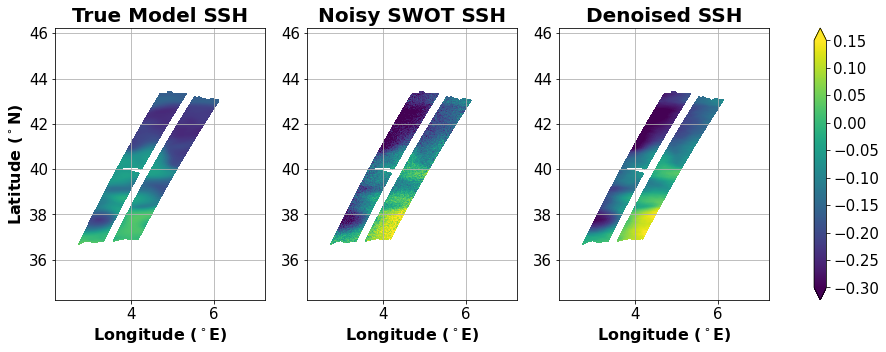

In [11]:
plt.figure(figsize=(16,5))
ax1 = plt.subplot(1,3,1)
SSHplot(ssh_model)
plt.grid()
plt.title('True Model SSH', fontweight = 'bold', fontsize=20)
plt.ylabel(r'Latitude (${^\circ}$N)', fontweight = 'bold', fontsize=16)

ax2 = plt.subplot(1,3,2)
SSHplot(ssh_obs)
plt.grid()
plt.title('Noisy SWOT SSH', fontweight = 'bold', fontsize=20)

ax3 = plt.subplot(1,3,3)
SSHplot(ssh_denoised)
plt.grid()
plt.title('Denoised SSH', fontweight = 'bold', fontsize=20)
axlist = [ax1,ax2,ax3]
cbar=plt.colorbar(ax=axlist, extend = 'both')
tick_font_size = 15
cbar.ax.tick_params(labelsize=tick_font_size)

#plt.savefig('SwotSSH1.png', bbox_inches='tight', pad_inches=0) # Just uncomment if you are happy with the image and want to save it

### Norm ${\nabla}$SSH Field
#### Reading the files

In [12]:
# Reading the denoised SSH Gradient file
Grad_ssh_denoised, lon, lat, x_ac, time = swotd.read_data(filedir +'MED_fastPhase_1km_swotFAST_c01_p009.nc_denoised_GradSSH_5_0.5.nc', 'SSH', 'lon', 'lat', 'x_ac', 'time')

#### Computing the first SSH derivative (${\nabla}$SSH) for all data types

In [13]:
Dgradhx, SWOTgradhx, Mgradhx = swotd.gradx(Grad_ssh_denoised), swotd.gradx(ssh_obs), swotd.gradx(ssh_model)
Dgradhy, SWOTgradhy, Mgradhy = swotd.grady(Grad_ssh_denoised), swotd.grady(ssh_obs), swotd.grady(ssh_model)

SWOTgradH = np.sqrt( np.square(SWOTgradhx) + np.square(SWOTgradhy) )
DenoisgradH = np.sqrt( np.square(Dgradhx) + np.square(Dgradhy) )
ModelgradH = np.sqrt( np.square(Mgradhx) + np.square(Mgradhy) )

<ipython-input-6-1073a0c6da66>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = plt.pcolormesh(lon_f, lat_f, ssh_f, vmin=vmin, vmax=vmax, cmap = 'inferno')


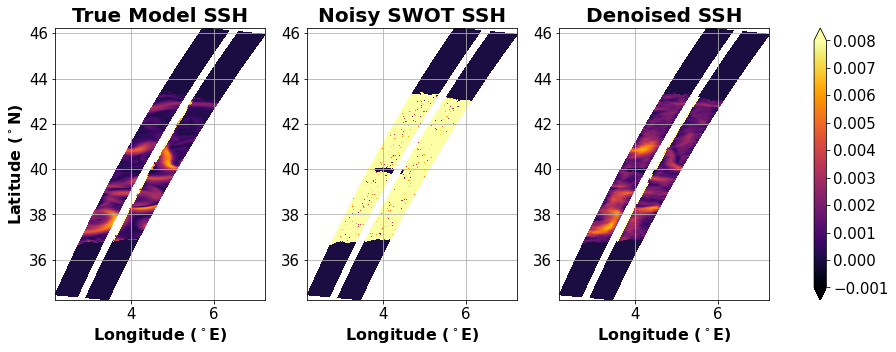

In [14]:
vmin = -0.001
vmax = 0.008

plt.figure(figsize=(16,5))
ax1 = plt.subplot(1,3,1)

GradSSHplot(ModelgradH)
plt.grid()
plt.title('True Model SSH', fontweight = 'bold', fontsize=20)
plt.ylabel(r'Latitude (${^\circ}$N)', fontweight = 'bold', fontsize=16)

ax2 = plt.subplot(1,3,2)
GradSSHplot(SWOTgradH)
plt.grid()
plt.title('Noisy SWOT SSH', fontweight = 'bold', fontsize=20)

ax3 = plt.subplot(1,3,3)
GradSSHplot(DenoisgradH)
plt.grid()
plt.title('Denoised SSH', fontweight = 'bold', fontsize=20)
#plt.suptitle('GEOSTROPHIC VELOCITY FIELD', fontsize=16, fontweight = 'bold')

axlist = [ax1,ax2,ax3]
cbar = plt.colorbar(ax=axlist, extend = 'both')
tick_font_size = 15
cbar.ax.tick_params(labelsize=tick_font_size)

#plt.savefig('SwotGeos1.png', bbox_inches='tight', pad_inches=0) # Just uncomment if you are happy with the image and want to save it

### ${\Delta}$SSH Field
#### Reading the files

In [15]:
Lap_ssh_denoised, lon, lat, x_ac, time = swotd.read_data(filedir +'MED_fastPhase_1km_swotFAST_c01_p009.nc_denoised_LapSSH_6_1.4.nc', 'SSH', 'lon', 'lat', 'x_ac', 'time')

#### Computing the second SSH derivative (${\Delta}$SSH) for all data types

In [16]:
DenoisLap, SWOTLap, ModelLap = swotd.laplacian(Lap_ssh_denoised), swotd.laplacian(ssh_obs), swotd.laplacian(ssh_model)

<ipython-input-7-8f273d9a591c>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = plt.pcolormesh(lon_f, lat_f, ssh_f, vmin=vmin, vmax=vmax, cmap = 'ocean_r')


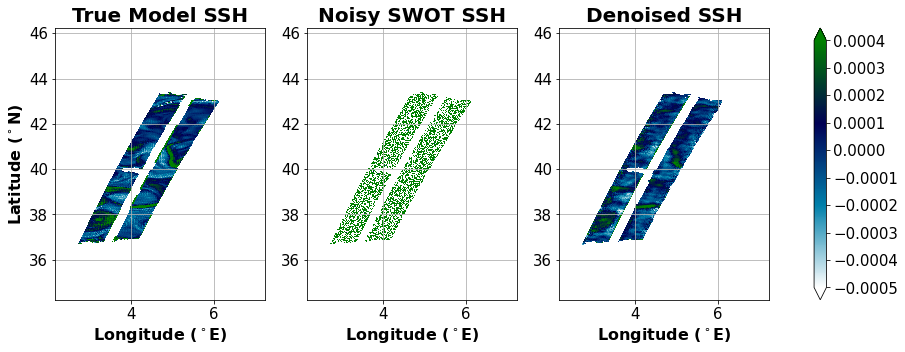

In [17]:
vmin = -0.0005
vmax = 0.0004

plt.figure(figsize=(16,5))
ax1 = plt.subplot(1,3,1)
LapSSHplot(ModelLap)
plt.grid()
plt.title('True Model SSH', fontweight = 'bold', fontsize=20)
plt.ylabel(r'Latitude (${^\circ}$N)', fontweight = 'bold', fontsize=16)

ax2 = plt.subplot(1,3,2)
LapSSHplot(SWOTLap)
plt.grid()
plt.title('Noisy SWOT SSH', fontweight = 'bold', fontsize=20)

ax3 = plt.subplot(1,3,3)
LapSSHplot(DenoisLap)
plt.grid()
plt.title('Denoised SSH', fontweight = 'bold', fontsize=20)
#plt.suptitle('LAPLACIAN FIELD', fontsize=16, fontweight = 'bold')

axlist = [ax1,ax2,ax3]
cbar=plt.colorbar(ax=axlist, extend = 'both')
tick_font_size = 15
cbar.ax.tick_params(labelsize=tick_font_size)

#plt.savefig('SwotLap1.png', bbox_inches='tight', pad_inches=0) # Just uncomment if you are happy with the image and want to save it

## 2. Variational Regularization Method

In [18]:
swotd.SWOTdenoise(filename, output_filename)

Method: var_reg_fista
Iteration reached: 2000
norm/epsilon = 25.56
Filtered field in  example_data/MED_fastPhase_1km_swotFAST_c01_p009_denoised.nc


The function can also be called by providing the appropriate arrays as keywords arguments: ```ssh, lon, lat, x_ac, time```. In the example below, these arrays are first read in the SWOT file using the ```read_data``` function of the module:

In [19]:
ssh, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time')

ssh_den = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time)


Method: var_reg_fista
Iteration reached: 2000
norm/epsilon = 25.56


### Plot the initial SSH field, and the denoised field

<ipython-input-4-1441ddd15aa1>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs = plt.pcolormesh(lon_f, lat_f, ssh_f, vmin=vmin, vmax=vmax)


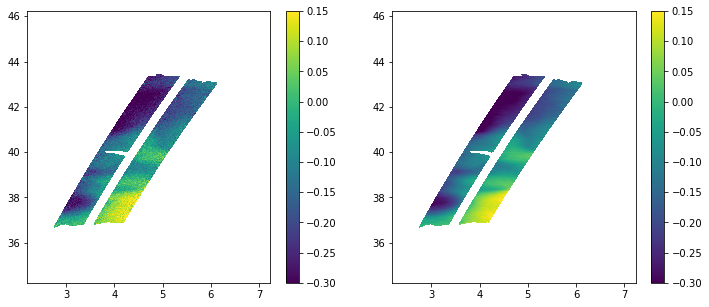

In [20]:
vmin = -0.3
vmax = 0.15

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
splot(ssh)
plt.subplot(1,2,2)
splot(ssh_den)

### For further check, read previously created file and plot SSH:

In [ ]:
filename_den = filedir + 'MED_fastPhase_1km_swotFAST_c01_p009_denoised.nc'


In [ ]:
ssh_den2, lon, lat, x_ac, time = swotd.read_data(filename_den, 'SSH', 'lon', 'lat', 'x_ac', 'time')
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
splot(ssh)
plt.subplot(1,2,2)
splot(ssh_den2)

# Now trying giving an output_filename instead of the dafault 'None':

In [ ]:
outfiledir = filedir 
filename_den = outfiledir + 'MED_fastPhase_1km_swotFAST_c01_p009_denoised_try2.nc'   # created by the module

swotd.SWOTdenoise(filename, filename_den)

In [ ]:
ssh_den2, lon, lat, x_ac, time = swotd.read_data(filename_den, 'SSH', 'lon', 'lat', 'x_ac', 'time')
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
splot(ssh)
plt.subplot(1,2,2)
splot(ssh_den2)

## 2. Optional parameters

In addition to the arguments described above, the ```SWOTdenoise``` function takes 5 optional arguments:

- ```method```: ```gaussian```, ```boxcar```, or ```var_reg_fista```;
- ```param```: number for ```gaussian``` and ```boxcar```; 3-entry tuple for ```var_reg_fista```;
- ```itermax```: only for ```var_reg_fista```: maximum number of iterations in the gradient descent algortihm;
- ```epsilon```: only for ```var_reg_fista```: convergence criterium for the gradient descent algortihm;
- ```inpainting```: if ```True```, the nadir gap is inpainted. If ```False```, it is not and the returned SSH array is of the same shape as the original one. If the ```SWOTdenoise``` function is called using arrays (see above description) with ```inpainting=True```, then it returns SSH, lon, and lat arrays. If it is called using arrays with ```inpainting=False```, it returns only SSH, since lon and lat arrays are the same as for the input field.

Without the necessary arguments, denoising is performed using a default method with default parameter(s) identified to be optimal.

## 3. Examples 
Examples below are given using the second method to call the function: giving arrays as arguments. The arrays are first read in the input file using the ```read_data``` function.

In [ ]:
ssh, lon, lat, x_ac, time = swotd.read_data(filename, 'SSH_obs', 'lon', 'lat', 'x_ac', 'time')

In [ ]:
splot(ssh)

### Gaussian filter:

In [ ]:
ssh_gau, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='gaussian', param=10.)
splot(ssh_gau)


### Boxcar filter:

In [ ]:
ssh_box, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='boxcar', param=4.)
splot(ssh_box)

### First order (gradients) regularization filter:
The function prints the number of iterations of the gradient descent method, and the convergence ratio. The convergence ratio is defined here as the ratio between the norm of the descent increment and the convergence factor (equal to 1e-9 by default). Iterations stops when the convergence ratio is below 1.

In [ ]:
ssh_vr1, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg_fista', param=(10.,0,0) )
splot(ssh_vr1)

### Second order (laplacian) regularization filter:

In [ ]:
ssh_vr2, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg_fista', param=(0,1,0) )
splot(ssh_vr2)

### Third order (gradient of laplacian) regularization filter:

In [ ]:
ssh_vr3, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg_fista', param=(0,0,1) )
splot(ssh_vr3)

### Combined orders regularization filter:

In [ ]:
ssh_vr, _ = swotd.SWOTdenoise(ssh=ssh, lon=lon, lat=lat, x_ac=x_ac, time=time, method='var_reg_fista', param=(1,2,4) )
splot(ssh_vr)

In [5]:
def comp_rmse(true, field):
    """Compute Root Mean Square Error (RMSE):
    Inputs:
    - true: domain grid, 2D arrays
    - denoised:
    Output:
    - real number. """
    h = np.mean(field - true)**2
    return np.sqrt(h)

In [16]:
# Computing the RMSEs from the denoised files

bf1, bf2 = [46], [0.6] #np.arange(44,50,8), np.arange(0,5,2)
n1, n2 = len(bf1), len(bf2)
sshd = np.empty((n1,n2)) 
rmse = np.empty((n1,n2))

rmseGeosv = np.empty((n1,n2))
rmseLap = np.empty((n1,n2))

gradhx = swotd.gradx(ssh_model)
gradhy = swotd.grady(ssh_model)
ssh_geosv = np.sqrt( np.square(gradhx) + np.square(gradhy) )

ssh_lap = swotd.laplacian(ssh_model)

for param1 in range(n1):
    std_space = bf1[param1]
    for param2 in range(n2):
        std_photo = bf2[param2]
        output_filename = 'tata'+str(std_space)+'_'+str(std_photo)+'.nc'
        ssh_1_01, lon, lat, x_ac, time = swotd.read_data(output_filename, 'SSH', 'lon', 'lat', 'x_ac', 'time')
        sshd = ssh_1_01
        
        Dgradhx = swotd.gradx(sshd)
        Dgradhy = swotd.grady(sshd)
        
        rmse[param1, param2] = comp_rmse(ssh_model, sshd)
            
        geosv = np.sqrt( np.square(Dgradhx) + np.square(Dgradhy) )
        rmseGeosv[param1, param2] = comp_rmse(ssh_geosv, geosv)
        
        Lap = swotd.laplacian(sshd)
        rmseLap[param1, param2] = comp_rmse(ssh_lap, Lap)

In [98]:
# RMSEs for the Noisy field
Nrmse = comp_rmse(ssh_model, ssh)

Ngradhx = swotd.gradx(ssh)
Ngradhy = swotd.grady(ssh)
Ngeosv = np.sqrt( np.square(Ngradhx) + np.square(Ngradhy) )           

NrmseGeosv = comp_rmse(ssh_geosv, Ngeosv)
        
NLap = swotd.laplacian(ssh)
NrmseLap = comp_rmse(ssh_lap, NLap)

In [7]:
swotd.SWOTdenoise(filename, output_filename, method = "bilateral_filter", param = (30.0, 0.6))

Method: bilateral_filter
0.0%
16.52892561983471%
33.05785123966942%
49.586776859504134%
66.11570247933884%
82.64462809917356%
99.17355371900827%
Filtered field in  example_data/MED_fastPhase_1km_swotFAST_c01_p009_denoised.nc


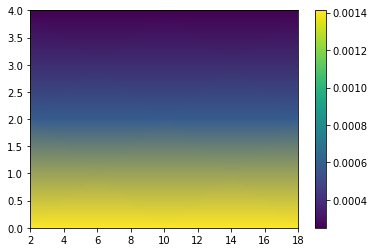

In [139]:
# Plot pcolormesh of RMSE for all parameters

cf=plt.pcolormesh(bf1, bf2, rmseGeosv, shading='gouraud')
cbar=plt.colorbar(cf)

In [23]:
for i in range(102):
        for j in range(1342):
            rmse_test = comp_rmse(ssh_model, ssh_1_01)